In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [ ]:
url = 'https://drive.google.com/file/d/1_gvIy2MoOTeX4oEk8xaa_1Wo1wwnEjS-/view?usp=sharing'
url2 = 'https://drive.google.com/uc?id='+ url.split('/')[-2]
df = pd.read_csv(url2)
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [ ]:
df["Churn"] = df["Churn"].astype("int64")
d = {"No": False, "Yes": True}
df["International plan"] = df["International plan"].map(d)
df["Voice mail plan"] = df["Voice mail plan"].map(d)


In [ ]:
#Добавим новый временной признак Lifetime - время от момента заключения контракта до выгрузки данных

np.random.seed(42)
n_churn = len(df[df['Churn']==1])
noise = df[df['Churn']==0]['Account length'].max() // 3
df['Lifetime'] = df['Account length']
df.loc[df['Churn']==1, ['Lifetime']] = df[df['Churn']==1]['Lifetime'] + pd.Series(np.round(np.random.uniform(0, noise, n_churn*8)))
df['Lifetime'] = df['Lifetime'].astype("int64")
df[df['Churn']==1].head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,Lifetime
10,IN,65,415,False,False,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,1,67
15,NY,161,415,False,False,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,1,176
21,CO,77,408,False,False,0,62.4,89,10.61,169.9,121,14.44,209.6,64,9.43,5.7,6,1.54,5,1,88
33,AZ,12,408,False,False,0,249.6,118,42.43,252.4,119,21.45,280.2,90,12.61,11.8,3,3.19,1,1,89
41,MD,135,408,True,True,41,173.1,85,29.43,203.9,107,17.33,122.2,78,5.50,14.6,15,3.94,0,1,175


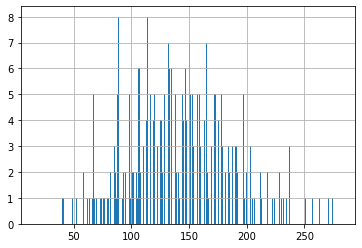

In [ ]:
#Распределение ушедших клиентов по признаку Lifetime
df[df['Churn']==1]['Lifetime'].hist(bins=n_churn)

In [108]:
#Сортируем клиентов от самых старых до новых

df = df.sort_values(['Lifetime'], ascending=False)

In [ ]:
#Удаляем из признаков линейно-зависимые и штат
 
y = df['Churn']
X = df.drop(['Churn', 'State','Total day minutes','Total eve minutes','Total night minutes','Total intl minutes', 'Lifetime'], axis=1)

In [ ]:
#Разбиваем исходную выборку на тестовую и обучающую

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

##Построим новую базовую модель (случайный лес) на упорядоченных данных

In [ ]:
# Инициализируем случайный лес с максимальной длиной 4

rfc_base_model = RandomForestClassifier(max_depth=4, random_state=42, n_jobs=-1)

In [ ]:
#Обучаем случайный лес и оцениванием качество модели на тестовой выборке

rfc_base_model.fit(X_train, y_train)
pred_proba = rfc_base_model.predict_proba(X_test)
roc_score_rfc_base = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score_rfc_base)

roc на test 0.8819355346973687


In [ ]:
#Оцениванием качество модели методом кросс-валидации

cv_scores = cross_val_score(rfc_base_model, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)
mean_roc_auc = np.mean(cv_scores)
cv_scores = cross_val_score(rfc_base_model, X_train, y_train, scoring='precision', cv=5, n_jobs=-1)
mean_precision = np.mean(cv_scores)
cv_scores = cross_val_score(rfc_base_model, X_train, y_train, scoring='recall', cv=5, n_jobs=-1)
mean_recall = np.mean(cv_scores)
print('mean roc_auc', mean_roc_auc)
print('mean precision', mean_precision)
print('mean recall', mean_recall)

mean roc_auc 0.9123981814534826
mean precision 0.8
mean recall 0.08640148011100832


##Улучшение модели: бустинг

In [ ]:
'''
grid = {'max_depth': [None, 3, 4 ,5 ,6],
        'learning_rate': [0 , 0.01, 0.1, 0.3],
        'n_estimators': [100, 200, 300, 500],
        'reg_alpha': [0 , 0.01, 0.1, 0.3],
        'reg_lambda': [0 , 0.01, 0.1, 0.3],}
'''
    


In [ ]:
'''
xg_model = XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=42) 

clf = GridSearchCV(xg_model, grid, n_jobs=-1, 
                   cv=5, 
                   scoring='roc_auc',
                   verbose=5)

clf.fit(X_train, y_train)
'''

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 556 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 646 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 934 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1132 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1366 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1770 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2320 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 2662 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 3040 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 3942 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 4392 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 5366 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 5888 tasks      | e

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0, 0.01, 0.1, 0.3],
                         'max_depth': [None, 3, 4, 5, 6],
                         'n_estimators': [100, 200, 300,

In [ ]:
'''
xg_params = clf.best_params_
xg_estimator = clf.best_estimator_
xg_score = clf.best_score_
xg_cv = clf.cv_results_
print(xg_params)
print(xg_estimator)
print(xg_score)
#print(xg_cv)
'''

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0.3, 'reg_lambda': 0.01}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0.3, reg_lambda=0.01, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
0.9312792372222439


In [ ]:
'''
pred_proba_xg = xg_estimator.predict_proba(X_test)
roc_score_xg = roc_auc_score(y_test, pred_proba_xg[:, 1])
print('roc на test', roc_score_xg)
'''

roc на test 0.9074858757062145


##Улучшение модели: случайный лес

In [ ]:
'''
grid = {'max_depth': [3, 4 ,5 ,6, 10, 13],
        'n_estimators': [100, 200, 300, 400],
        'criterion': ['gini', 'entropy']}
'''

In [ ]:
'''
rfc_model = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)
clf = GridSearchCV(rfc_model, grid, n_jobs=-1, 
                   cv=5, 
                   scoring='roc_auc',
                   verbose=5)

clf.fit(X_train,y_train)
'''

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=True, random_state=42,
                                     

In [ ]:
'''
rfc_params = clf.best_params_
rfc_estimator = clf.best_estimator_
rfc_score = clf.best_score_
rfc_cv = clf.cv_results_
print(rfc_params)
print(rfc_estimator)
print(rfc_score)
#print(rfc_cv)
'''

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)
0.9292403091144095


In [ ]:
'''
pred_proba_rfc = rfc_estimator.predict_proba(X_test)
roc_score_rfc = roc_auc_score(y_test, pred_proba_rfc[:, 1])
print('roc на test', roc_score_rfc)
'''

roc на test 0.9005841042609224


##Улучшение модели: используем признак State для бустинга

In [ ]:
state_enc = LabelEncoder()
df["State"] = state_enc.fit_transform(df["State"])

In [ ]:
#Удаляем из признаков линейно-зависимые и Lifetime
 
y = df['Churn']
X = df.drop(['Churn', 'Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes', 'Lifetime'], axis=1)

In [ ]:
#Разбиваем исходную выборку на тестовую и обучающую

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
'''
grid = {'max_depth': [None, 3, 4 ,5 ,6],
        'learning_rate': [0 , 0.01, 0.1, 0.3],
        'n_estimators': [100, 200, 300, 500],
        'reg_alpha': [0 , 0.01, 0.1, 0.3],
        'reg_lambda': [0 , 0.01, 0.1, 0.3],}
''' 

In [ ]:
'''
xg_model = XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=42) 

clf = GridSearchCV(xg_model, grid, n_jobs=-1, 
                   cv=5, 
                   scoring='roc_auc',
                   verbose=5)

clf.fit(X_train, y_train)
'''

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1022 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1256 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1526 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 2210 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 2552 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2930 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 3722 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 4172 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 4658 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 5558 tasks      | e

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0, 0.01, 0.1, 0.3],
                         'max_depth': [None, 3, 4, 5, 6],
                         'n_estimators': [100, 200, 300,

In [ ]:
'''
xg_params = clf.best_params_
xg_estimator = clf.best_estimator_
xg_score = clf.best_score_
xg_cv = clf.cv_results_
print(xg_params)
print(xg_estimator)
print(xg_score)
#print(xg_cv)
'''

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.01}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0.1, reg_lambda=0.01, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
0.9325733087787194


In [ ]:
'''
pred_proba_xg = xg_estimator.predict_proba(X_test)
roc_score_xg = roc_auc_score(y_test, pred_proba_xg[:, 1])
print('roc на test', roc_score_xg)
'''

roc на test 0.9094919756004232


##Валидация модели

Бустинг показал лучшее качество, используем эту модель.

In [ ]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, reg_alpha=0.1, reg_lambda=0.01)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0.1, reg_lambda=0.01, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [38]:
pred_proba_xgb = xgb_model.predict_proba(X_test)
roc_score_xgb = roc_auc_score(y_test, pred_proba_xgb[:, 1])
print('roc на test', roc_score_xgb)

roc на test 0.9019233799266212


In [ ]:

cv_scores_roc_auc = cross_val_score(xgb_model, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)
mean_roc_auc = np.mean(cv_scores_roc_auc)
cv_scores = cross_val_score(xgb_model, X_train, y_train, scoring='precision', cv=5, n_jobs=-1)
mean_precision = np.mean(cv_scores)
cv_scores = cross_val_score(xgb_model, X_train, y_train, scoring='recall', cv=5, n_jobs=-1)
mean_recall = np.mean(cv_scores)

print('mean roc_auc', mean_roc_auc)
print('mean precision', mean_precision)
print('mean recall', mean_recall)


mean roc_auc 0.9282482369506578
mean precision 0.8938938254727729
mean recall 0.6767807585568917


In [ ]:
#Качество модели по фолдам
cv_scores_roc_auc

array([0.89376529, 0.9689441 , 0.95031056, 0.87895773, 0.9492635 ])

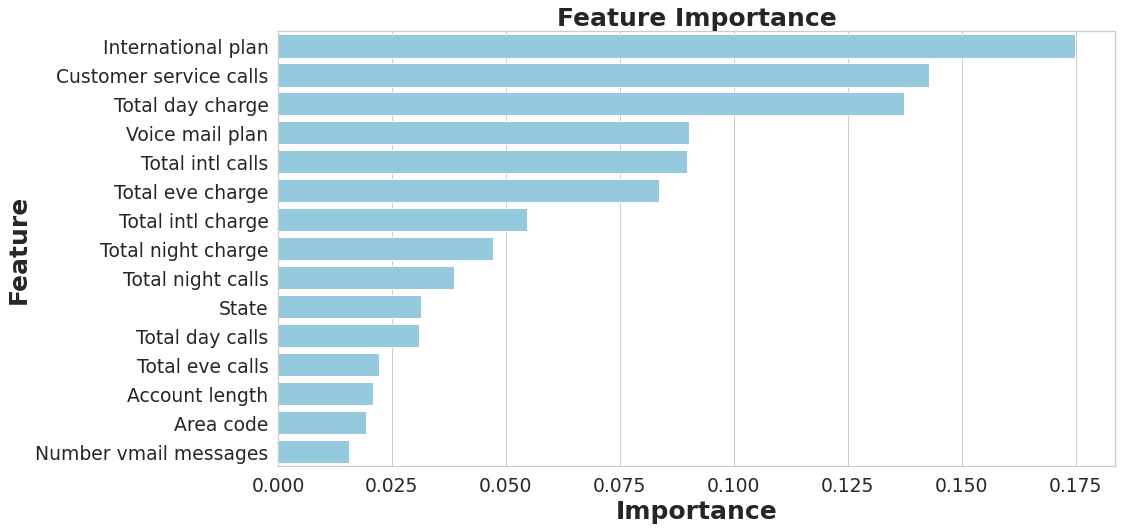

In [ ]:
#Важность признаков

xgb_importances = pd.Series(xgb_model.feature_importances_)
xgb_features = X.columns
feats = {}

for feature, importance in zip(xgb_features, xgb_importances):
    feats[feature] = importance
xgb_viz = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
xgb_viz = xgb_viz.sort_values(by='Importance', ascending=False)
xgb_viz = xgb_viz.reset_index()
xgb_viz = xgb_viz.rename(columns={'index': 'Feature'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.barplot(x=xgb_viz['Importance'], y=xgb_viz['Feature'], data=xgb_viz, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Feature', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
plt.show()

##Сегменты

In [89]:
idx_df = len(df) // 2
df_train = df[:idx_df].drop(['Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes', 'Lifetime'], axis=1)
df_test = df[idx_df:].drop(['Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes', 'Lifetime'], axis=1)

In [90]:
corr_matrix_train = df_train.corr()
corr_matrix_test = df_test.corr()

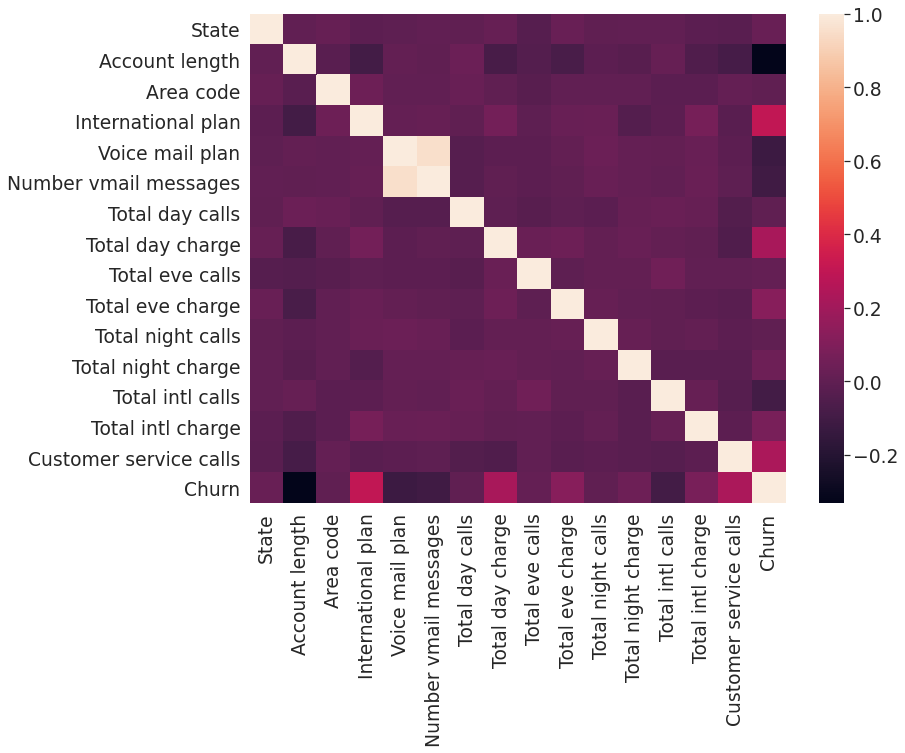

In [105]:
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix_train);

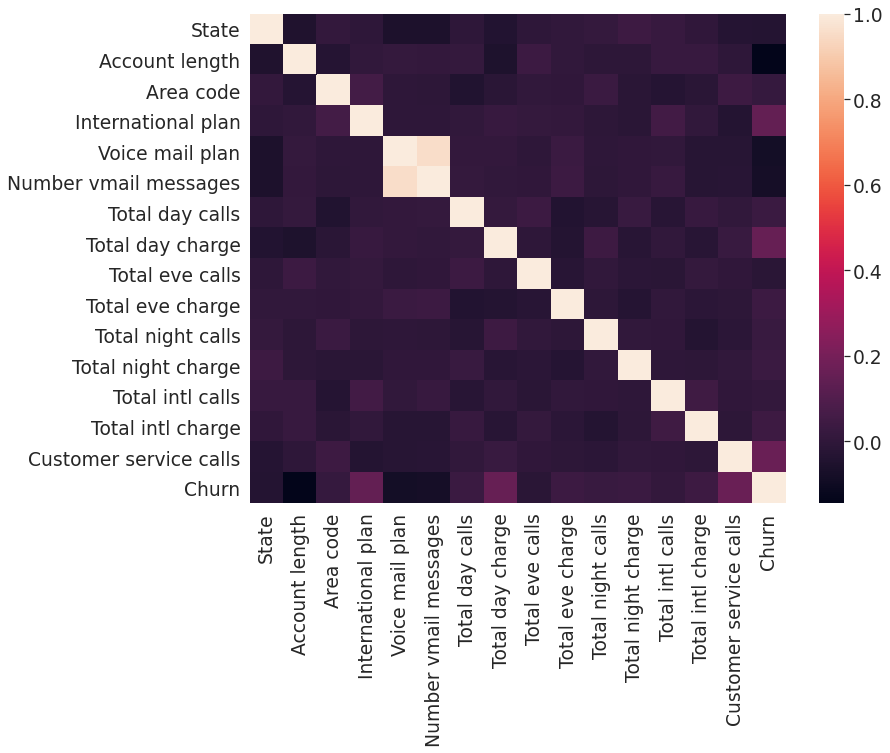

In [107]:
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix_test);

In [110]:
features = list(
    set(df_train.columns)
    - set(['Churn', 'Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes', 'Lifetime'])
)

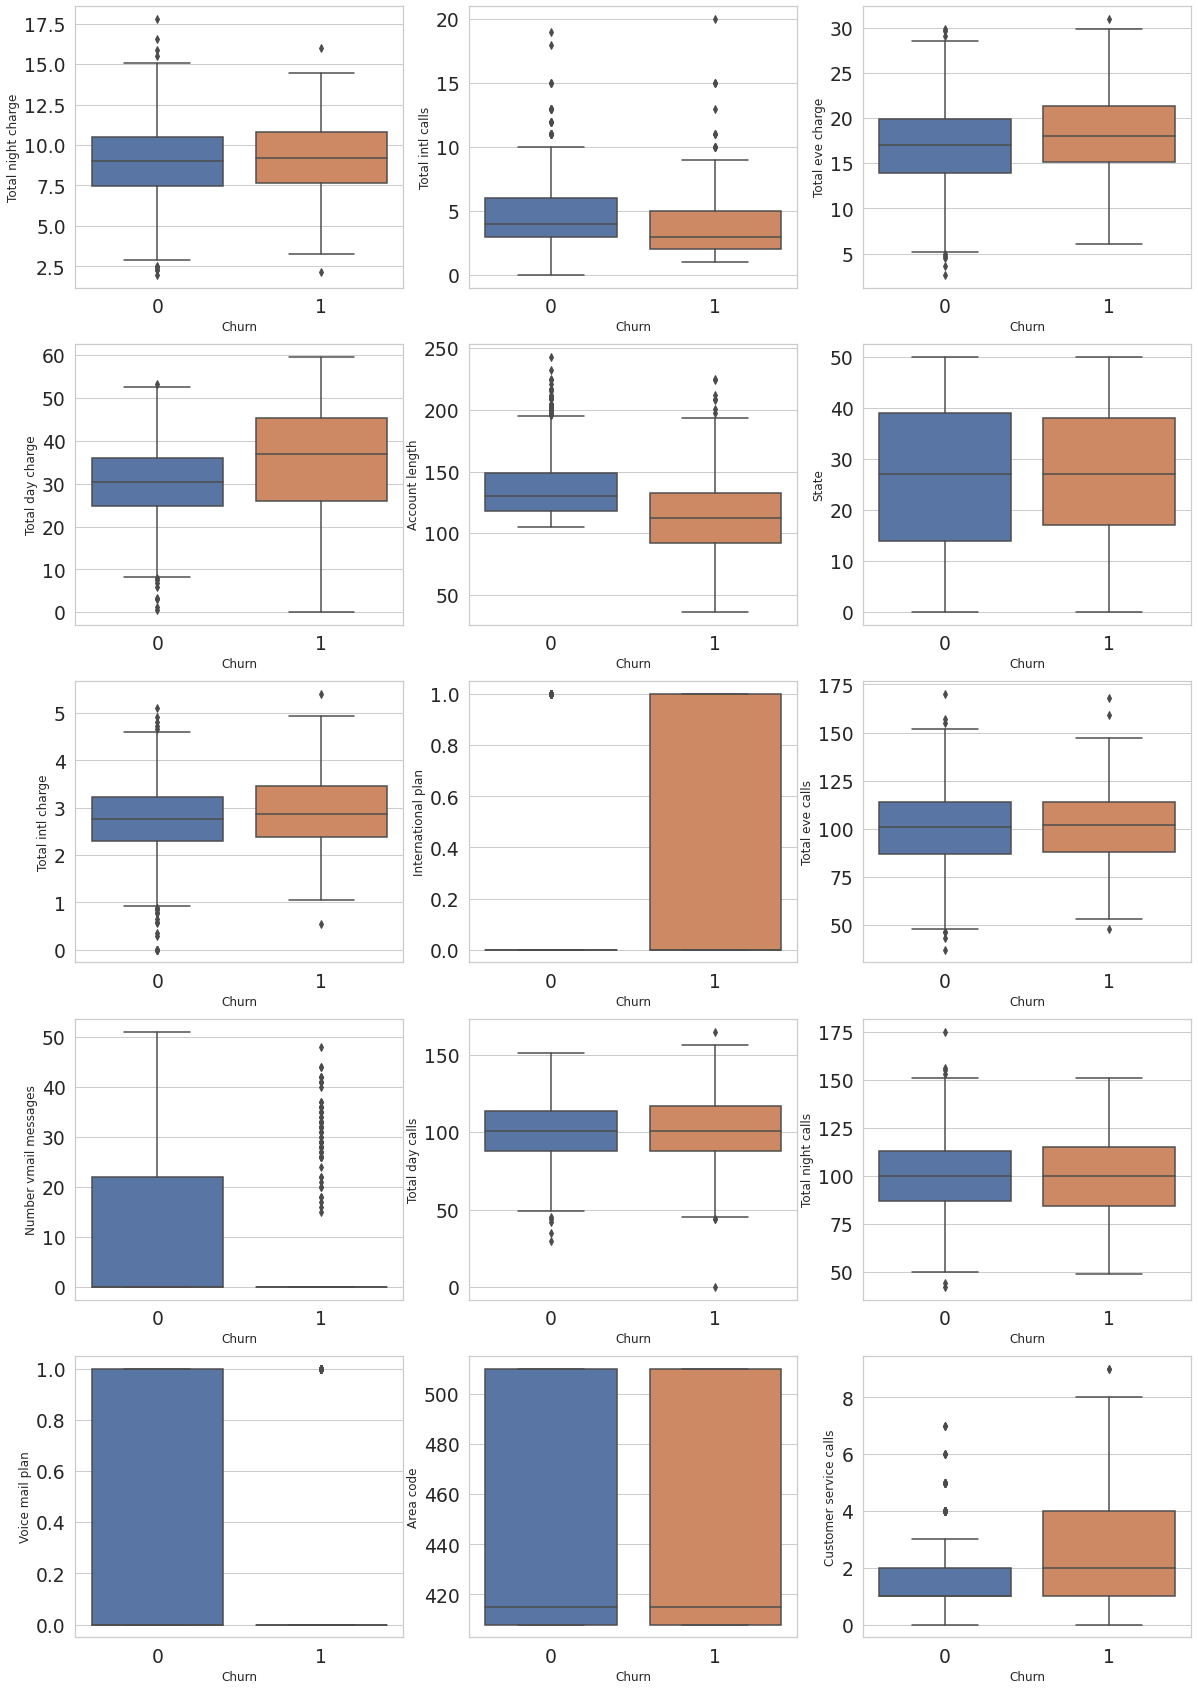

In [100]:
nrows = 5
ncols = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))

for idx, feat in enumerate(features):
    sns.boxplot(x="Churn", y=feat, data=df_train, ax=axes[int(idx / ncols), idx % ncols])
    #axes[int(idx / 5), idx % 5].legend()
    axes[int(idx / ncols), idx % ncols].set_xlabel("Churn", fontsize=12)
    axes[int(idx / ncols), idx % ncols].set_ylabel(feat, fontsize=12);

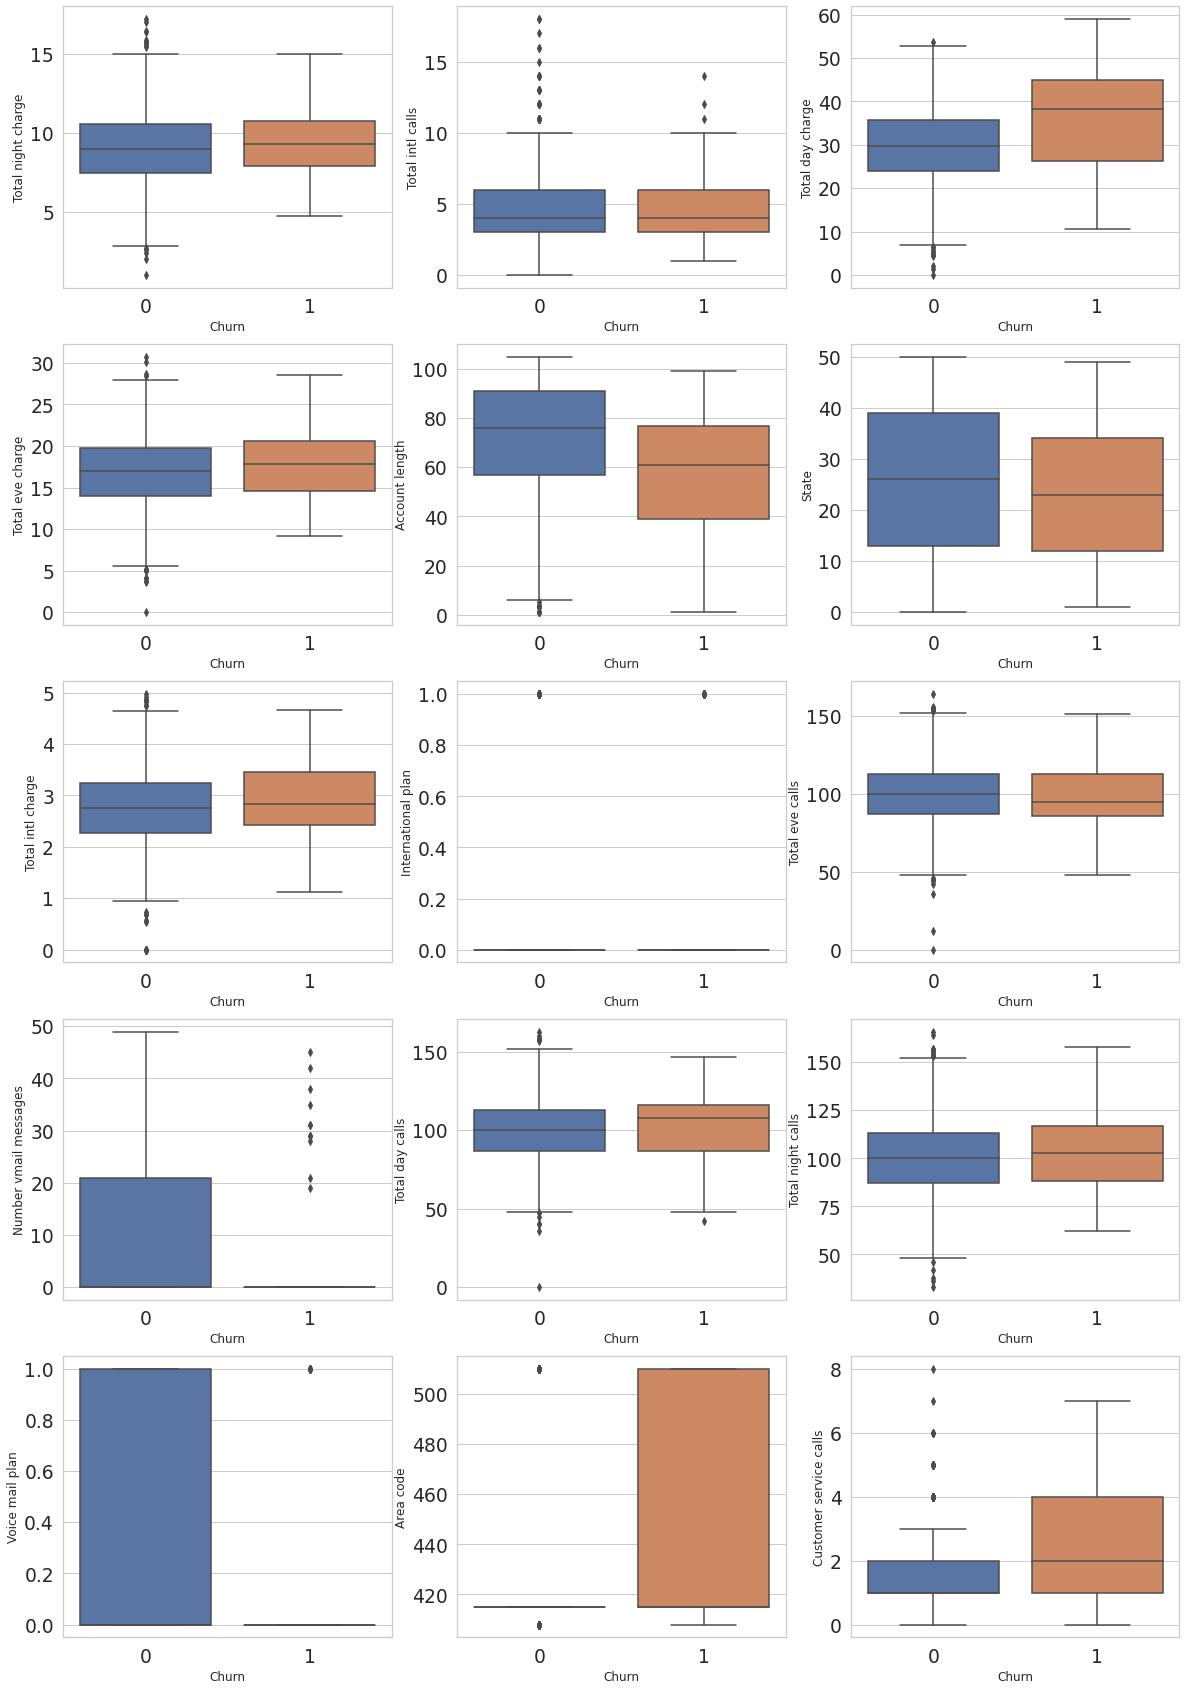

In [82]:
nrows = 5
ncols = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))

for idx, feat in enumerate(features):
    sns.boxplot(x="Churn", y=feat, data=df_test, ax=axes[int(idx / ncols), idx % ncols])
    #axes[int(idx / 5), idx % 5].legend()
    axes[int(idx / ncols), idx % ncols].set_xlabel("Churn", fontsize=12)
    axes[int(idx / ncols), idx % ncols].set_ylabel(feat, fontsize=12);

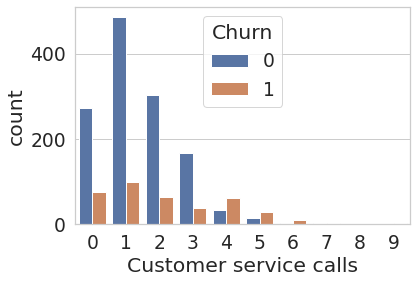

In [83]:
sns.countplot(x="Customer service calls", hue="Churn", data=df_train);

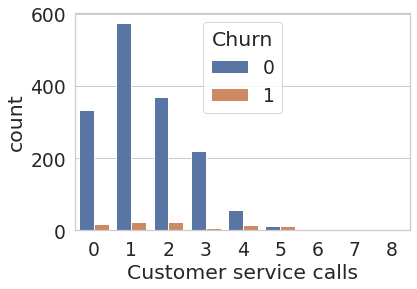

In [84]:
sns.countplot(x="Customer service calls", hue="Churn", data=df_test);

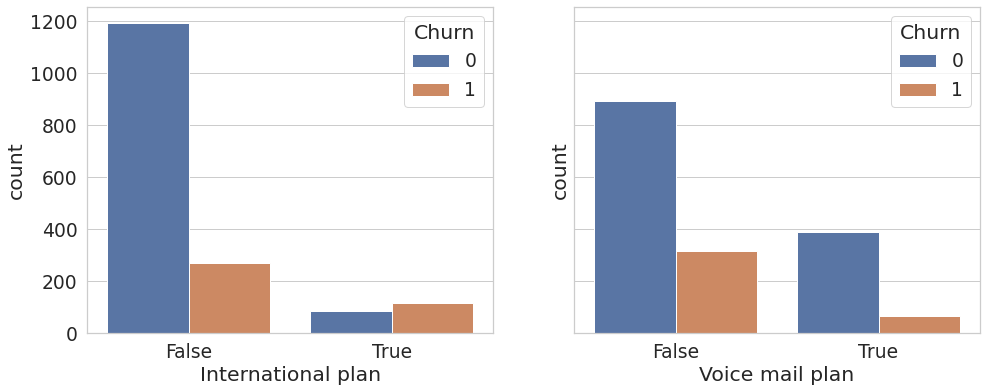

In [86]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16, 6))

sns.countplot(x="International plan", hue="Churn", data=df_train, ax=axes[0])
sns.countplot(x="Voice mail plan", hue="Churn", data=df_train, ax=axes[1]);

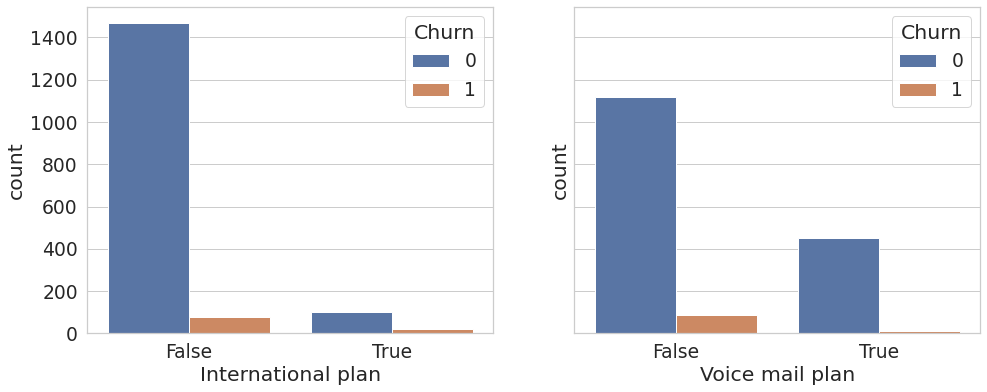

In [87]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16, 6))

sns.countplot(x="International plan", hue="Churn", data=df_test, ax=axes[0])
sns.countplot(x="Voice mail plan", hue="Churn", data=df_test, ax=axes[1]);

##Деградация модели

Будем оценивать изменение качества модели на новых данных по 2,5%.

In [111]:
#Разобьем тестовый набор данных на 20 частей
n_part = 20
n_observ = len(y_test) // n_part

for part in range(n_part - 1):
    globals()[f'X_test{part}'] = X_test[part * n_observ : (part + 1) * n_observ]
    globals()[f'y_test{part}'] = y_test[part * n_observ : (part + 1) * n_observ]
globals()[f'X_test{part + 1}'] = X_test[(part + 1) * n_observ :]
globals()[f'y_test{part + 1}'] = y_test[(part + 1) * n_observ :]

##**Добавить оси на график**

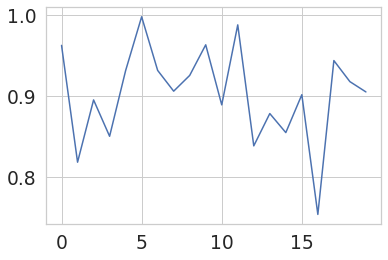

In [113]:
#Последовательно оценим качество модели на полученных наборах данных

roc_scores = []
for part in range(n_part):
    pred_proba = xgb_model.predict_proba(globals()[f'X_test{part}'])
    roc_score = roc_auc_score(globals()[f'y_test{part}'], pred_proba[:, 1])
    roc_scores.append(roc_score)

pd.Series(roc_scores).plot();

In [51]:
df['Lifetime'].describe()

count    3333.000000
mean      106.845785
std        43.455400
min         1.000000
25%        77.000000
50%       105.000000
75%       135.000000
max       281.000000
Name: Lifetime, dtype: float64

Для обучения модели были взяты данные с 281 дня по 105, для оценки деградаци со 105 по 1. За данный период тенденция падения качества модели не обнаружена.